# ViewNormalization is all you need

# Library

In [1]:
import glob
import os
import yaml
import pandas as pd

def check_config(reg_exp, record_list=[]):
    # Find all directories matching pattern
    dirs = glob.glob(reg_exp)
    dirs = [dir for dir in dirs if os.path.isdir(dir)]

    # Initialize dictionary to store the extracted information
    data = {}

    # Iterate over the directories and extract information from config.yaml
    for directory in dirs:
        config_path = os.path.join(directory, 'config.yaml')
        with open(config_path, 'r') as file:
            config = yaml.safe_load(file)
            # Check for each record in the list
            for record in record_list:
                if record in config:
                    if record not in data:
                        data[record] = [config[record]]
                    else:
                        data[record].append(config[record])
                else:
                    print(f"Record '{record}' not found in directory '{directory}'")

    # Create a DataFrame with the extracted information
    df = pd.DataFrame(data)
    
    # Add 'dir_name' column with directory names
    df['dir_name'] = dirs

    # Set 'dir_name' as the first column
    df = df.set_index('dir_name').reset_index()

    # Display the DataFrame as a table
    return df


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import os
import numpy as np 

def compare_curve(reg_exp1, reg_exp2, file_list=[]):
    # Find all directories matching pattern
    dirs = glob.glob(reg_exp1)
    dirs = [dir for dir in dirs if os.path.isdir(dir)]

    # Prepare a color cycle for plot lines
    colors = plt.cm.viridis(np.linspace(0, 1, len(dirs)))

    # Create main figure and axis
    fig, axes = plt.subplots(len(file_list), 1, sharex=True, figsize=(10, 15))
    
    # Generate plot title based on the files to be plotted
    title = ', '.join([file.replace('_', ' ').title() for file in file_list]) + ' Over Epochs'
    fig.suptitle(title)
    
    flag=True
    x_min, x_max = float('inf'), float('-inf')  # Initialize min and max values for x-axis limits
    
    for i, dir in enumerate(dirs):
        # Extract value from directory name
        value = re.search(reg_exp2, dir).group(1)

        dfs = []
        for file_name in file_list:
            try:
                # Read the CSV files
                df = pd.read_csv(f"{dir}/default_{file_name}.csv")
                df_others = pd.read_csv(f"{dir}/default_others.csv")

                # Merge the dataframes on 'step'
                df = df.merge(df_others, on='step', how='inner')

                # Group by 'epoch' and calculate mean
                df = df.groupby('epoch').mean().reset_index()
                dfs.append(df)

                # Plot
                axes[file_list.index(file_name)].plot(df['epoch'], df[file_name], color=colors[i], label=f' {value}')
                axes[file_list.index(file_name)].set_ylabel(file_name)
                axes[file_list.index(file_name)].grid(True)
                 
                # Add stable solution indicator for 'representation_std'
                if file_name == 'representation_std' and flag:
                    axes[file_list.index(file_name)].axhline(y=1/np.sqrt(2048), color='grey', linestyle='--')
                    axes[file_list.index(file_name)].text(0, 1/np.sqrt(2048), '$1/\sqrt{d}$', color='black', va='bottom', ha='left', fontsize=10, weight='bold')

                flag=False

                # Update x-axis limits
                x_min = min(x_min, df['epoch'].min())
                x_max = max(x_max, df['epoch'].max())

            except FileNotFoundError:
                print(f"No file named 'default_{file_name}.csv' in directory '{dir}'")
                continue

    # Add legend
    for ax in axes:
        ax.legend(loc='best')
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.set_xlim([x_min, x_max])  # Set x-axis limit based on calculated min and max values

    # Show the plots
    plt.tight_layout()
    plt.show()


In [3]:

import pandas as pd
import re
import matplotlib.pyplot as plt
def extract_reg(df: pd.DataFrame, pattern: str, name: str) -> pd.DataFrame:
    # Identify if the pattern targets a string, float or a number
    if 'REG' in pattern:
        reg_pattern = pattern.replace("REG", "([a-zA-Z0-9_.]+)")
    else:
        reg_pattern = pattern
        
    df[name] = df['dir_name'].apply(lambda x: re.findall(reg_pattern, x))
    
    # If the matched pattern is a number or a float, convert it accordingly
    df[name] = df[name].apply(lambda x: int(x[0]) if x and x[0].isdigit() else 
                               (float(x[0]) if x and is_float(x[0]) else (x[0] if x else None)))
    return df

def is_float(n):
    try:
        float_n = float(n)
    except ValueError:
        return False
    else:
        return '.' in n
import matplotlib.pyplot as plt
import seaborn as sns

def plot_lines(df, column):
    # Use seaborn styles
    sns.set_style("whitegrid")
    
    df = df.sort_values(by=column)
    
    plt.figure(figsize=(10, 6))
    
    # Plotting each of the accuracy measures with different line styles and colors
    plt.plot(list(df[column]), df['linear_top1_accuracy'], label='Top-1 Accuracy', linestyle='-', color='blue')
    plt.plot(list(df[column]), df['linear_top3_accuracy'], label='Top-3 Accuracy', linestyle='--', color='green')
    plt.plot(list(df[column]), df['linear_top1_average_accuracy'], label='Top-1 Avg Accuracy', linestyle='-.', color='red')
    plt.plot(list(df[column]), df['linear_knn_top1_accuracy'], label='KNN Top-1 Accuracy', linestyle=':', color='purple')
    
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Accuracy Measures over ' + column, fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True)
    plt.show()


def plot_perform(df, column):
    # Use seaborn styles
    sns.set_style("whitegrid")
    
    df = df.sort_values(by=column)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot 'GPU Usage(Gbyte)' on the first y-axis (left)
    ax1.plot(list(df[column]), df['GPU Usage(Gbyte)'], label='GPU Usage(Gbyte)', linestyle='-', color='blue')
    ax1.set_ylabel('GPU Usage (Gbyte)', fontsize=12)
    
    ax2 = ax1.twinx()  # Create a secondary y-axis sharing the same x-axis

    # Plot 'running time(min)' on the secondary y-axis (right)
    ax2.plot(list(df[column]), df['runing time(min)'], label='runing time(min)', linestyle='--', color='green')
    ax2.set_ylabel('Running Time (min)', fontsize=12)
    
    plt.xlabel(column, fontsize=12)
    plt.title('Performances over ' + column, fontsize=14)
    
    # Combine the legends from both plots
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines1 + lines2, labels1 + labels2, loc='lower right', fontsize=10)
    
    plt.grid(True)
    plt.show()


In [4]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define function to create bar plot
def plot_bar(df, axis="", legend="", metric=""):
    if axis and legend and metric:
        grouped_df = df.groupby([axis, legend])[metric].sum().unstack()

        bar_width = 0.2  # Adjusted bar width
        index = np.arange(len(grouped_df.index))* 0.7
        
        # Dynamically adjust figure size
        fig_width = len(grouped_df.index) * bar_width * 8
        plt.figure(figsize=(fig_width, 6))

        styles = [('white', 'k', '...'), ('white', 'k', '//')]  # Styles for each category
        
        for i, (colname, data) in enumerate(grouped_df.iteritems()):
            color, ec, hatch = styles[i % len(styles)]
            plt.bar(index + i * bar_width, data, width=bar_width, color=color, ec=ec, lw=0.8, hatch=hatch, label=colname)
        
        plt.xlabel(axis, fontsize=12)
        plt.ylabel(metric, fontsize=12)
        plt.title(f"Grouped Bar Plot: {metric} by {axis} and {legend}", fontsize=14)
        plt.xticks(index + bar_width/2, grouped_df.index, rotation=45, ha='right', fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend(title=legend)
        
        plt.grid(axis='y', linestyle='--')
        
        plt.tight_layout()
        plt.show()
    else:
        print("Please specify 'axis', 'legend', and 'metric' parameters.")
 

In [5]:
def show_batch_variance(root):
    # Read the CSV files
    df_std = pd.read_csv(root + 'default_representation_std.csv')
    df_loss = pd.read_csv(root + 'default_correlation.csv')
    df_accuracy = pd.read_csv(root + 'default_kNN_accuracy.csv')

    # Create main figure and axis with larger size
    fig, ax1 = plt.subplots(figsize=(10, 6))



    # Plot kNN Accuracy
    color = 'tab:green'
    ax1.set_xlabel('Step')
    ax1.set_ylabel('kNN Accuracy', color=color)
    line3, = ax1.plot(df_accuracy['step'], df_accuracy['kNN_accuracy'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create second y axis for Train Loss
    ax2 = ax1.twinx()
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    color = 'tab:red'
    ax2.set_ylabel('batch_correlation', color=color)
    line2, = ax2.plot(df_loss['step'], df_loss['correlation'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Create third y axis for Standard Deviation
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    color = 'tab:blue'
    ax3.set_ylabel('Standard Deviation', color=color)
    line1, = ax3.plot(df_std['step'], df_std['representation_std'], color=color)
    ax3.tick_params(axis='y', labelcolor=color)
    ax3.set_ylim (0.1**2,2 **1)
    ax3.set_yscale("log")

    ax3.axhline(y=1/np.sqrt(2048), color='grey', linestyle='--')
    ax3.text(0, 1/np.sqrt(2048), '$1/\sqrt{d}$', color='blue', va='bottom', ha='left', fontsize=10, weight='bold')
    plt.title('Variance between Batch over Steps')
    ax1.grid(False)
    ax2.grid(False)
    ax3.grid(False)

    # Show the plots
    fig.tight_layout()
    plt.show()

def show_view_variance(root):
    # Read the CSV files
    df_std = pd.read_csv(root + 'default_view_variance.csv')
    df_loss = pd.read_csv(root + 'default_train_loss.csv')
    df_accuracy = pd.read_csv(root + 'default_kNN_accuracy.csv')

    # Create main figure and axis with larger size
    fig, ax1 = plt.subplots(figsize=(10, 6))



    # Plot kNN Accuracy
    color = 'tab:green'
    ax1.set_xlabel('Step')
    ax1.set_ylabel('kNN Accuracy', color=color)
    line3, = ax1.plot(df_accuracy['step'], df_accuracy['kNN_accuracy'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create second y axis for Train Loss
    ax2 = ax1.twinx()
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    color = 'tab:red'
    ax2.set_ylabel('train_loss', color=color)
    line2, = ax2.plot(df_loss['step'], df_loss['train_loss'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Create third y axis for Standard Deviation
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    color = 'tab:blue'
    ax3.set_ylabel('view_variance', color=color)
    line1, = ax3.plot(df_std['step'], df_std['view_variance'], color=color)
    ax3.tick_params(axis='y', labelcolor=color)
    ax3.set_ylim (0.1**2,2 **1)
    ax3.set_yscale("log")
 
    plt.title('Variance between View over Steps')
    ax1.grid(False)
    ax2.grid(False)
    ax3.grid(False)

    # Show the plots
    fig.tight_layout()
    plt.show()

#

    

# Abstract

Multi-view self-supervised learning (SSL) faces challenges that can decrease accuracy, including the instability of multi-view representations. Bad augmentations, color space variations, and suboptimal alignment of representations across views contribute to this instability. 

This abstract proposes a method called multi-view self-supervised learning to improve the accuracy of SSL. By leveraging multiple augmented views of the original data, we aim to find representations that maximize the mutual information with the task while minimizing the mutual information with specific data augmentations. Additionally, we introduce a constraint to maximize the variance of the representations over the batch, promoting diverse and informative embeddings. Experimental results on CIFAR datasets show that our approach achieves a classification accuracy of 0.923, surpassing the state-of-the-art accuracy of 0.906. Multi-view SSL accelerates learning and enhances SSL models' performance.

# Introduction





#### Problem1: Instability of Multi View :   influence Accuracy

For SSL learning,the typical method only use two views, x0,x1=aug(x)  z0, z1=f(x0,x1),  
the previous method is to minimize the , distance(COuld be cos, could be l2, could be MSE or correlates) between z0, z1,
However, these could ahve problelm like, 

<u>**1. bad augmentation cause low accuracy**</u>

Give some formula to suggests

![](https://i.imgur.com/7qZxYSm.png)
- Reference: https://ar5iv.labs.arxiv.org/html/2005.10243
- Because: we should reduce the mutual information (MI) between views while keeping task-relevant information intact. 

<u>**2. Even good choice, the color space(far) could reveal more properties**</u> 

Give some formula to suggests
 


 
#### Problem2: The for downstream Transfer learning 

<u>**1. bigger space, more generalization**</u>

 Give some formula to suggests

#### Problem3: The unstable distribtuion make shake and hard to converge

<u>**1.multi variate distribution**</u> 

 Assume we have choose a good view, two views problem cause multi variate distribution
 
Give some formula to suggests



# Method


1. According to the Information Bottleneck (IB) theory, the optimal representation, $Z_X^*$, maximizes the mutual information with the task $T$ while minimizing the mutual information with the input data $X$. Mathematically: For a given task, we want 

    $$Z_X^* = \underset{Z_X}{\arg \min} I(Z_X ; X) \text { s.t. } I(Z_X ; T) \text { is maximized}.$$

2. For self-supervised learning, the aim is to find a representation that maximizes the mutual information with the task, while minimizing the mutual information with the specific data augmentations (denoted as "Aug"). We also add a constraint to maximize the variance of $Z$ over the batch. The optimization problem becomes:

   $$Z_X^* = \underset{Z_X}{\arg \min} I(Z_X ; \text{Aug}(X)) \text { s.t. } I(Z_X ; T) \text { is maximized, } \quad \sigma^2(Z_X) \text{ over the batch is maximized}.$$

Where $\sigma^2(Z_X)$ denotes the variance of $Z_X$ over the batch. This additional constraint encourages the model to learn diverse representations across different instances in the batch.

3. In the two-views case, the objective is to minimize the distance between the representations of the two views of the same instance. Formally: 

    $$\text{loss} = \text { distance}(z_{0, j, k}, z_{1,j, k}).$$ 

4. In the multi-view case, 

Let's define $X = \{x_0, x_1, ..., x_n\}$ as the different augmented views of the original data and $Z = \{z_0, z_1, ..., z_n\}$ as the corresponding representations produced by a model $f$, where $z_i = f(x_i)$. 

a. The final objective hypothesis space we are going to learn is `z_mean` for each batch and feature across all views as follows:
 $$z_{\text{mean}_{j, k}} = \frac{1}{n} \sum_{i=0}^{n} z_{i, j, k}.$$

Where:
- `i` ranges over the different views,
- `j` is the index of the batch, and
- `k` is the index of the feature.
 
b. The objective becomes minimizing the variance of the representations across different views of the same instance: 

$$\text{loss} = \frac{1}{n} \sum_{i=0}^{n} \text{distance }(z_{i, j, k}, z_{\text{mean}_{j, k}})^2.$$

### Why it work



#### <u>**1. Accelerate Task learning by focus on three direciton:</u>**

For each learning step, 
Assume Z' is theoretic Z' with Maxima Task related embedding,
as we get more views, Z_mean become unbias estimation of Z'

In the context of multi-view self-supervised learning, the task $T$ essentially becomes learning to generate similar representations for different views of the same instance. Therefore, the variance of $Z_X$ over different views is minimized (as captured by the loss function), while the variance of $Z_X$ over different instances in the batch is maximized (as given by the constraint $\sigma^2(Z_X)$ over the batch is maximized). This ensures that the representations are maximally informative about the instances they belong to 

`Formula to suggest why`


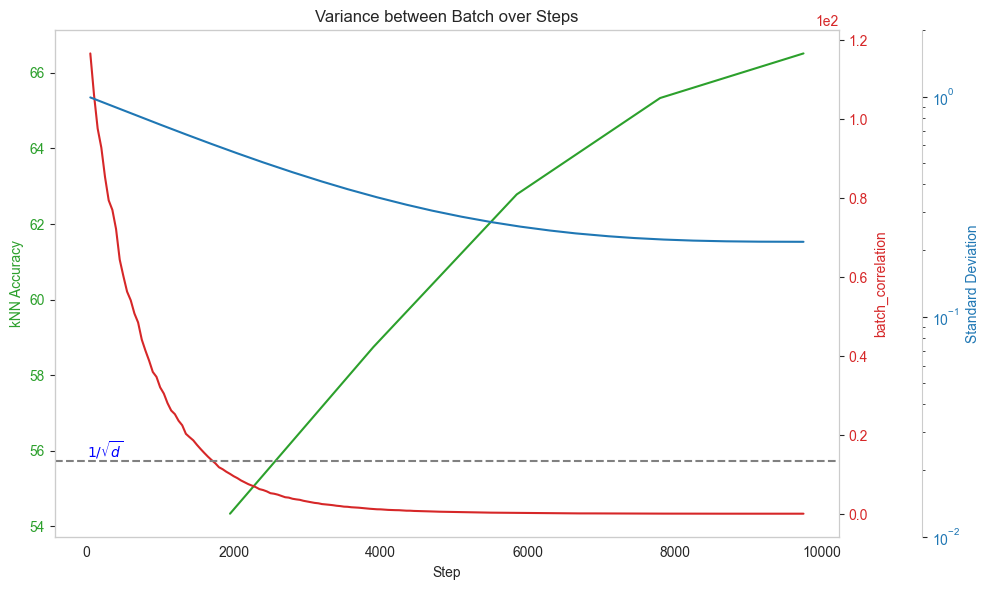

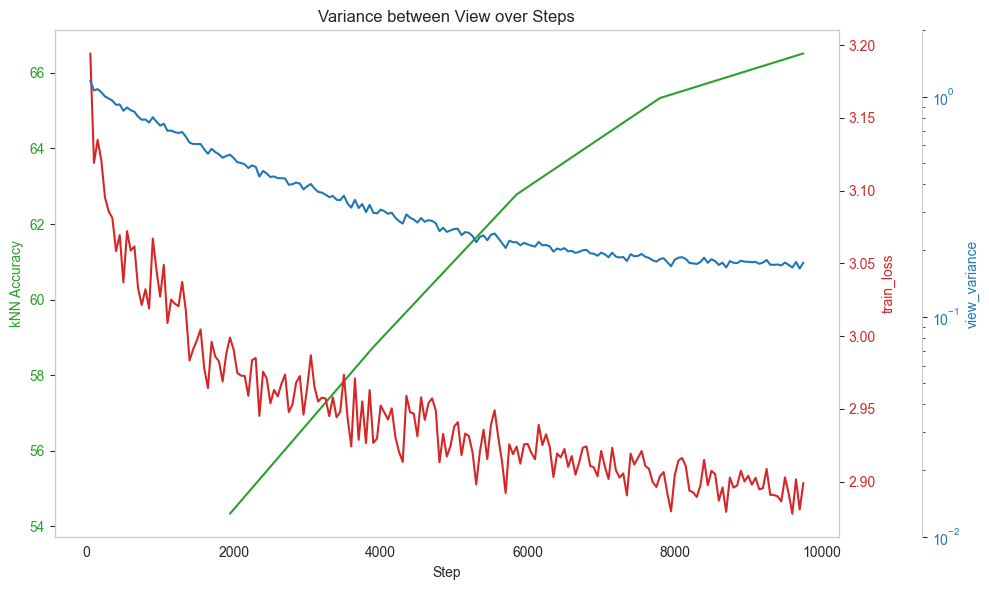

In [33]:
# For normal method it can effectively acclerate and stable the learning.
 
show_batch_variance(root="Model_SimCLR_VMmean_n_v4/") 
show_view_variance(root="Model_SimCLR_VMmean_n_v4/") 
 


#### (Important) fix the unbalance problem(bottleneck of VICREG and BT)
 
    
<u>**its focus too much on invariance, so that batch correlation and view variance is not good**

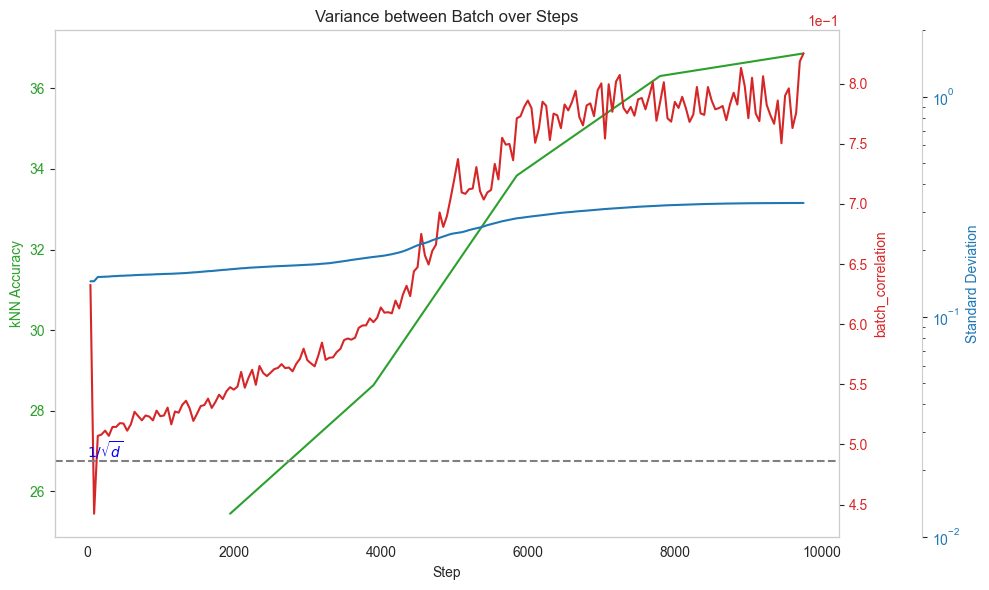

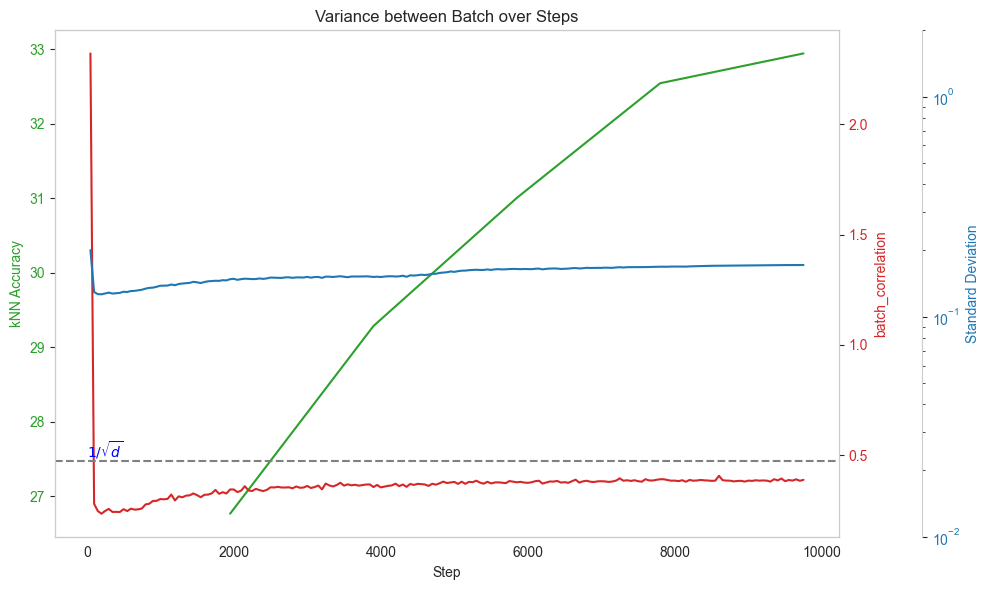

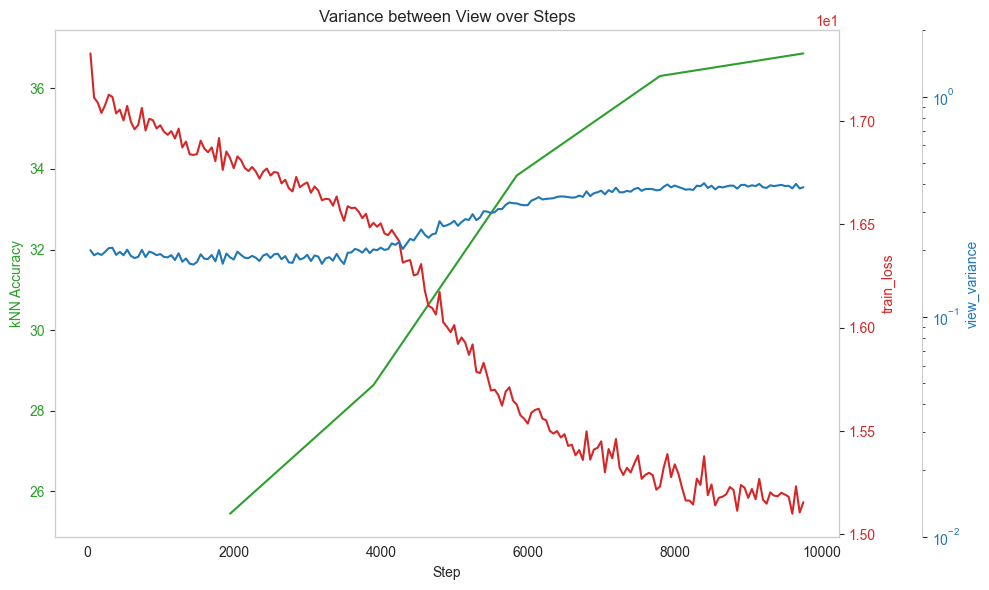

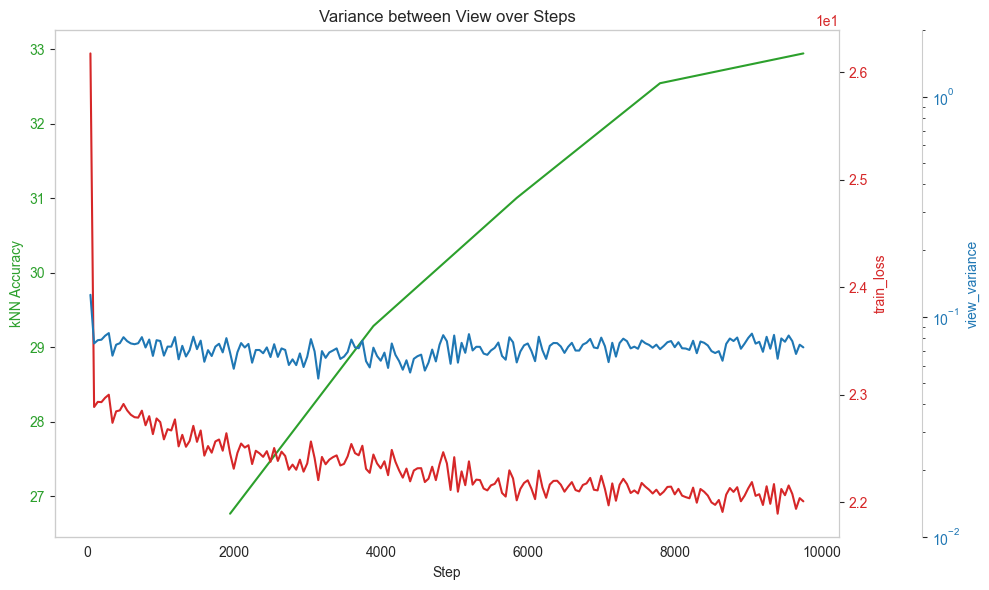

In [38]:
 show_batch_variance(root="Model_VICREG_VMmean_n_v4/") 
show_batch_variance(root="Model_VICREG_VMNone_v2/") 
show_view_variance(root="Model_VICREG_VMmean_n_v4/") 
 show_view_variance(root="Model_VICREG_VMNone_v2/") 


#### <u>**2. Global and Local Feature, Cover More  mutual information (MI) </u>**

`Formula to suggest why`



#### <u>**3. Global and Local Feature, Cover More  mutual information (MI) </u>**

`Formula to suggest why`



#### <u>**4. Add numeric stable to Avoid Multi variate distribution </u>**


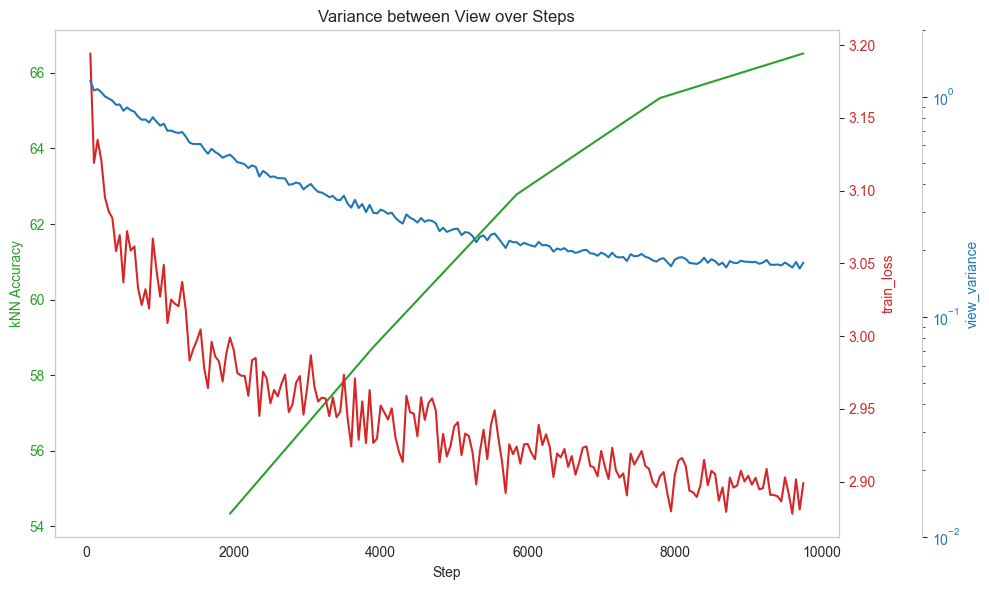

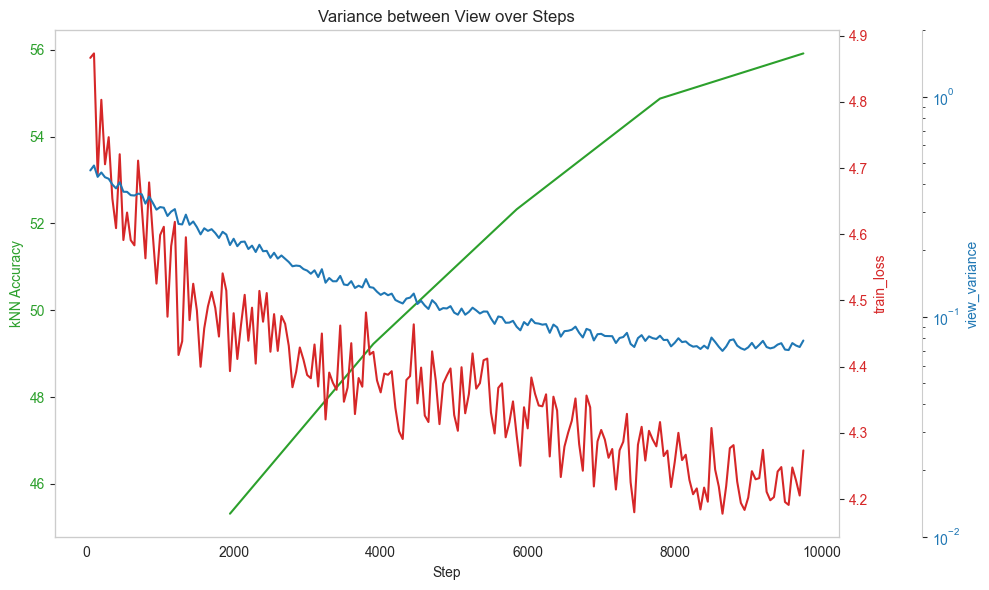

In [34]:
 
show_view_variance(root="Model_SimCLR_VMmean_n_v4/") 
show_view_variance(root="Model_SimCLR_VMNone_v2/") 
 


`Formula to suggest why`
 
### Experiment Implement Details


note for myself(only)
1 From view-batch Matrix to Standard Deviation of View
The pseudocode for BARLOW TWINS is shown as Algorithm 1.
location in matrix
Gradient direciton
Gradient compute
 

### Grid Search of View Strategy


1. how should we know which is better?  By accuracy, by its stable, by its performance


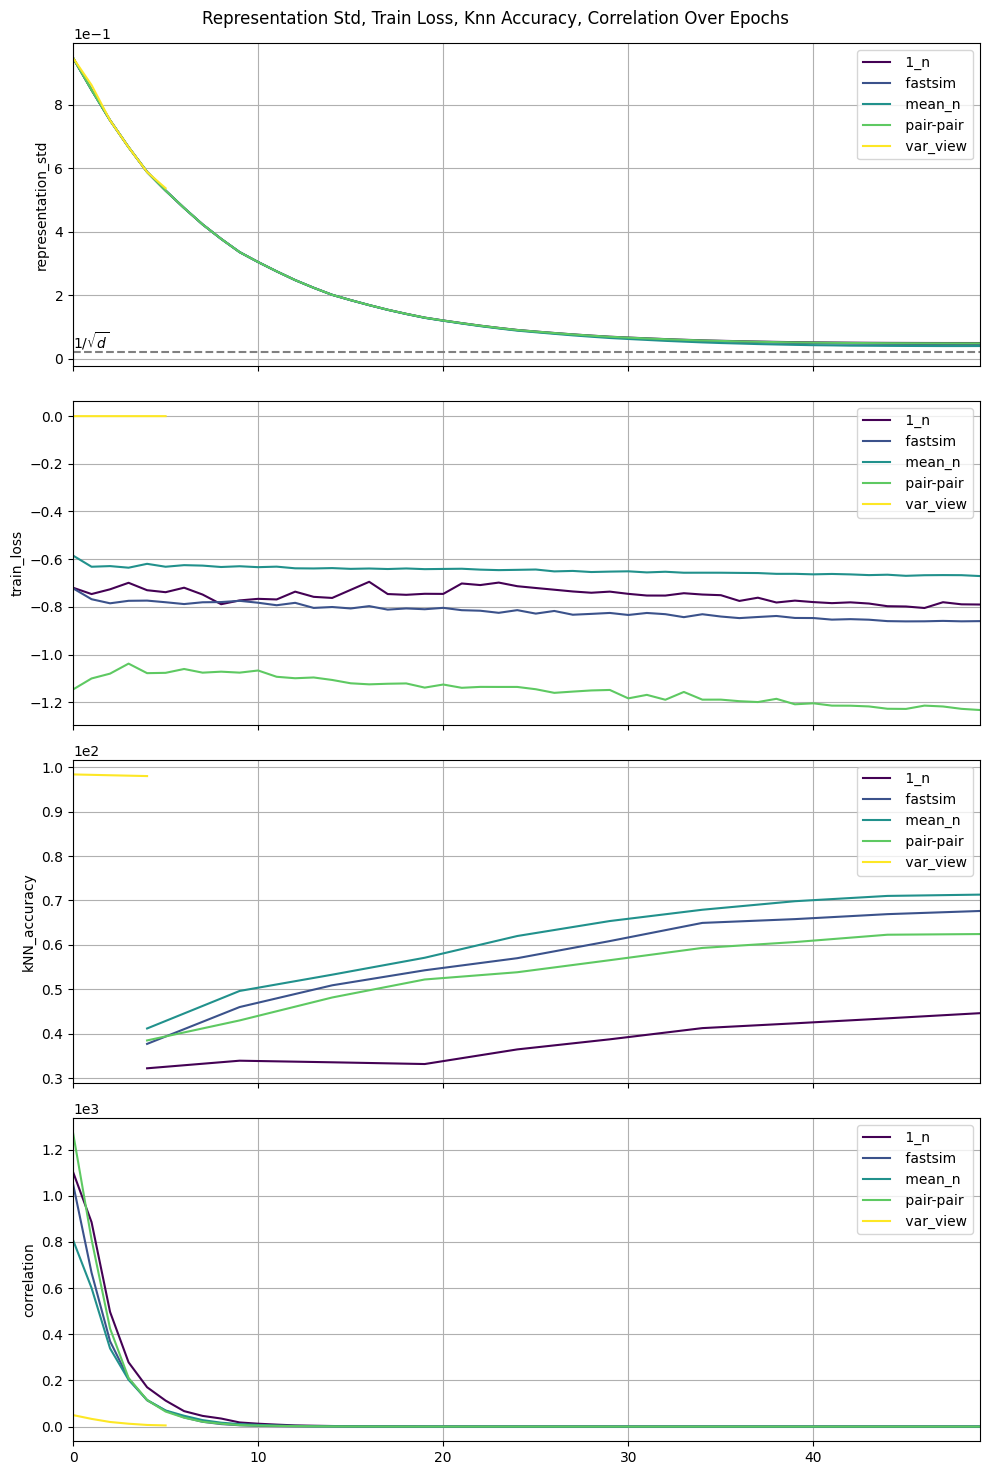

In [8]:
data = compare_curve("LNeg_VM*_PRTruenoBN_stTrue_b128_m50_v4",
                    r"LNeg_VM(.*)_PRTruenoBN_stTrue_b128_m50_v4", 
                    ['representation_std', 'train_loss', 'kNN_accuracy',"correlation"])
 

In [9]:
df = check_config("LNeg_VM*_PRTruenoBN_stTrue_b128_m50_v4", ['GPU Usage(Gbyte)', 'runing time(min)',"view_model"])
df

,dir_name,GPU Usage(Gbyte),runing time(min),view_model
0,LNeg_VM1_n_PRTruenoBN_stTrue_b128_m50_v4,0.661863,38.019100,1_n
1,LNeg_VMfastsim_PRTruenoBN_stTrue_b128_m50_v4,0.624603,38.201585,fastsim
2,LNeg_VMmean_n_PRTruenoBN_stTrue_b128_m50_v4,0.604017,37.094191,mean_n
3,LNeg_VMpair-pair_PRTruenoBN_stTrue_b128_m50_v4,0.651053,39.236466,pair-pair
4,LNeg_VMvar_view_PRTruenoBN_stTrue_b128_m50_v4,0.604021,1.464182,var_view


# Result


 
## Comparison with State-of-the-art： Refresh the Cifar

We compared in CIfar and realized SOTA


In [10]:
import pandas as pd

# Load spreadsheet
xl = pd.ExcelFile('Compare All Model Baseline.xlsx')

# Load a sheet into a DataFrame by its name
df = xl.parse('Sheet1')

df


,Model,Batch Size,Epochs,KNN Test Accuracy,Runtime,GPU Memory
0,BarlowTwins,128,200,0.842,375.9 Min,1.7 GByte
1,BYOL,128,200,0.869,121.9 Min,1.6 GByte
2,DCL,128,200,0.844,102.2 Min,1.5 GByte
3,DCLW,128,200,0.833,100.4 Min,1.5 GByte
4,DINO,128,200,0.840,120.3 Min,1.6 GByte
5,FastSiam,128,200,0.906,164.0 Min,2.7 GByte
6,Moco,128,200,0.838,128.8 Min,1.7 GByte
7,NNCLR,128,200,0.834,101.5 Min,1.5 GByte
8,SimCLR,128,200,0.847,97.7 Min,1.5 GByte
9,SimSiam,128,200,0.819,97.3 Min,1.6 GByte


## 3. It can easily improve Most current baselines
We are interested in comparisons between baseline networks and improved networks, not in achieving state-of-the-art performance on MNIST (the described architecture does not). 

C:\Users\isxzl\AppData\Local\Temp\ipykernel_6524\2573111900.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (colname, data) in enumerate(grouped_df.iteritems()):


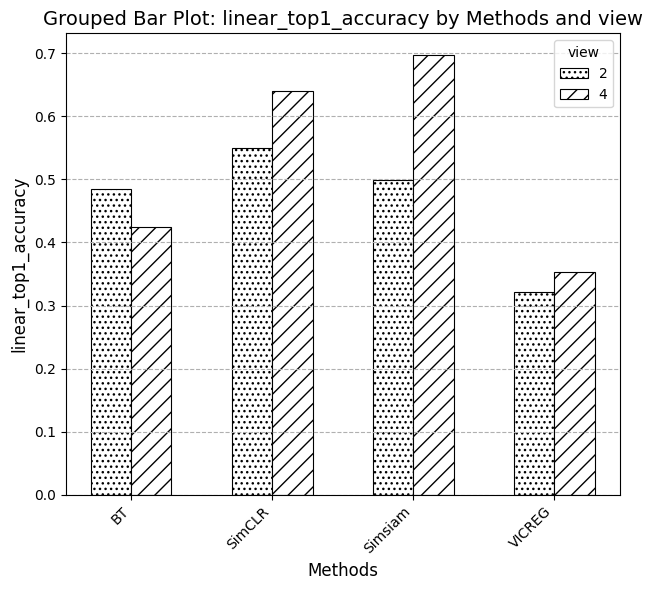

,dir_name,linear_top1_accuracy,view,Methods
0,Model_BT_VMmean_n_v4,0.425157,4,BT
1,Model_BT_VMNone_v2,0.484452,2,BT
2,Model_SimCLR_VMmean_n_v4,0.639836,4,SimCLR
3,Model_SimCLR_VMNone_v2,0.549545,2,SimCLR
4,Model_Simsiam_VMmean_n_v4,0.696430,4,Simsiam
5,Model_Simsiam_VMNone_n_v2,0.499450,2,Simsiam
6,Model_VICREG_VMmean_n_v4,0.352865,4,VICREG
7,Model_VICREG_VMNone_v2,0.321068,2,VICREG


In [17]:

ds=pd.read_csv("Model__.csv")
ds=ds[["dir_name","linear_top1_accuracy"]] #,"linear_top3_accuracy","linear_top1_average_accuracy","linear_knn_top1_accuracy"
df=extract_reg(ds,"_vREG","view")   
df=extract_reg(df,"Model_REG_VM","Methods")    

# Call the function with the DataFrame and column names
plot_bar(df, axis="Methods", legend="view", metric="linear_top1_accuracy")
ds

C:\Users\isxzl\AppData\Local\Temp\ipykernel_6524\2573111900.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (colname, data) in enumerate(grouped_df.iteritems()):


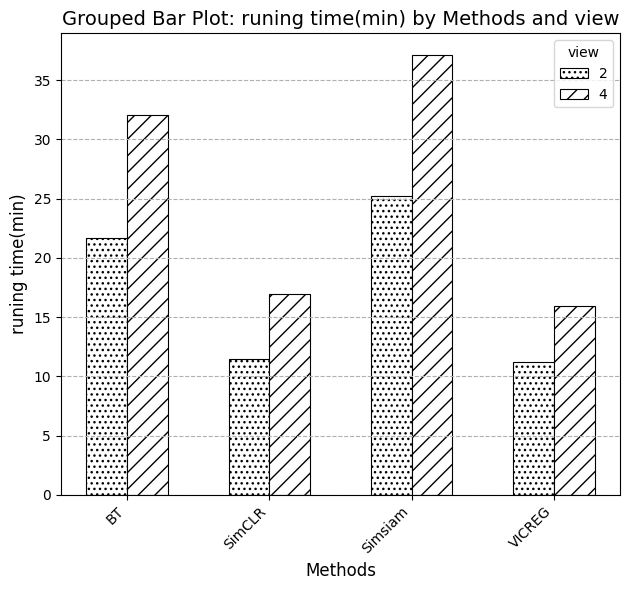

C:\Users\isxzl\AppData\Local\Temp\ipykernel_6524\2573111900.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (colname, data) in enumerate(grouped_df.iteritems()):


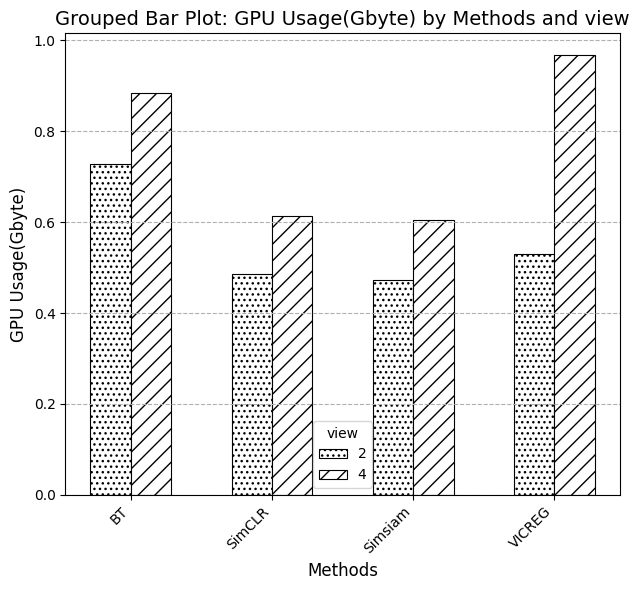

In [16]:
ds = check_config("Model_*", ['GPU Usage(Gbyte)', 'runing time(min)',"view_model"])
df=extract_reg(ds,"_vREG","view")   
df=extract_reg(df,"Model_REG_VM","Methods")    
plot_bar(df, axis="Methods", legend="view", metric='runing time(min)')

ds = check_config("Model_*", ['GPU Usage(Gbyte)', 'runing time(min)',"view_model"])
df=extract_reg(ds,"_vREG","view")   
df=extract_reg(df,"Model_REG_VM","Methods")    
plot_bar(df, axis="Methods", legend="view", metric='GPU Usage(Gbyte)')

 

# 4 Ablation Experiment


#### Influence of View Number


In [18]:
 

ds=pd.read_csv("LNeg_VMmean_n_PRTruenoBN_stTrue_b128_m50_v_.csv")
ds=ds[["dir_name","linear_top1_accuracy","linear_top3_accuracy","linear_top1_average_accuracy","linear_knn_top1_accuracy"]]
ds

,dir_name,linear_top1_accuracy,linear_top3_accuracy,linear_top1_average_accuracy,linear_knn_top1_accuracy
0,LNeg_VMmean_n_PRTruenoBN_stTrue_b128_m50_v10,0.754925,0.945205,0.754919,0.759224
1,LNeg_VMmean_n_PRTruenoBN_stTrue_b128_m50_v2,0.578542,0.872513,0.578542,0.592441
2,LNeg_VMmean_n_PRTruenoBN_stTrue_b128_m50_v4,0.697330,0.923408,0.697324,0.703730
3,LNeg_VMmean_n_PRTruenoBN_stTrue_b128_m50_v6,0.730027,0.938206,0.730018,0.732827
4,LNeg_VMmean_n_PRTruenoBN_stTrue_b128_m50_v8,0.747825,0.941506,0.747822,0.750625


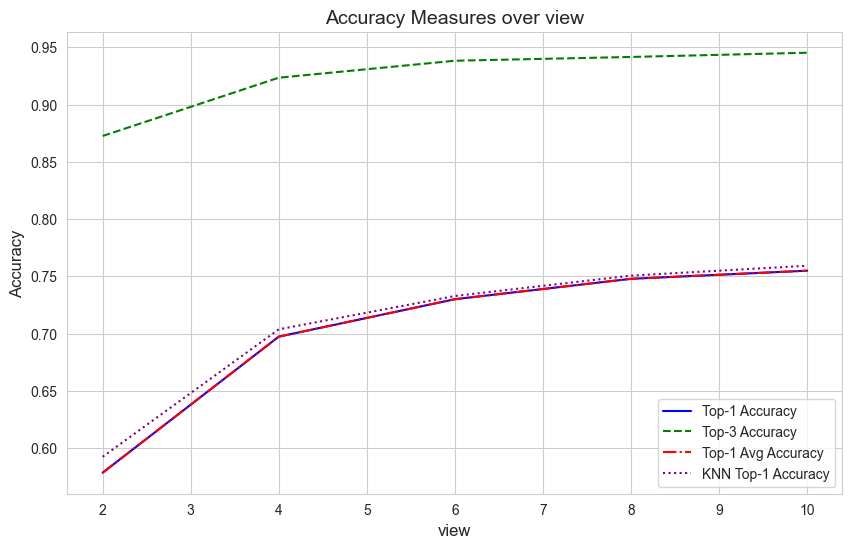

In [19]:
df=extract_reg(ds,"_b128_m50_vREG","view")    
plot_lines(df, 'view')


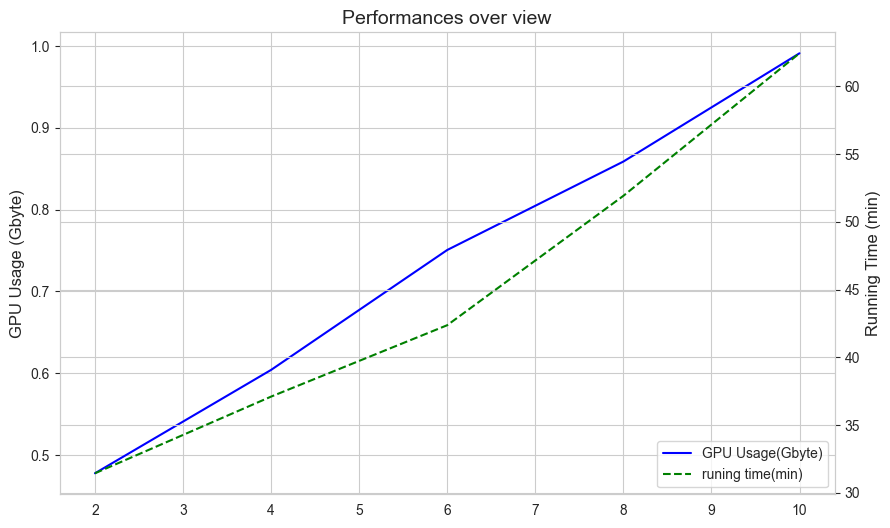

In [20]:
ds = check_config("LNeg_VMmean_n_PRTruenoBN_stTrue_b128_m50_v*", ['GPU Usage(Gbyte)', 'runing time(min)',"view_model"])

df=extract_reg(ds,"_b128_m50_vREG","view")    

plot_perform(df, 'view')

 
## 3. 
Influence of Batch Normalization

## 4.  
Loss function 

## 5.  
 Projection, Stop gradient , batch size etc,.

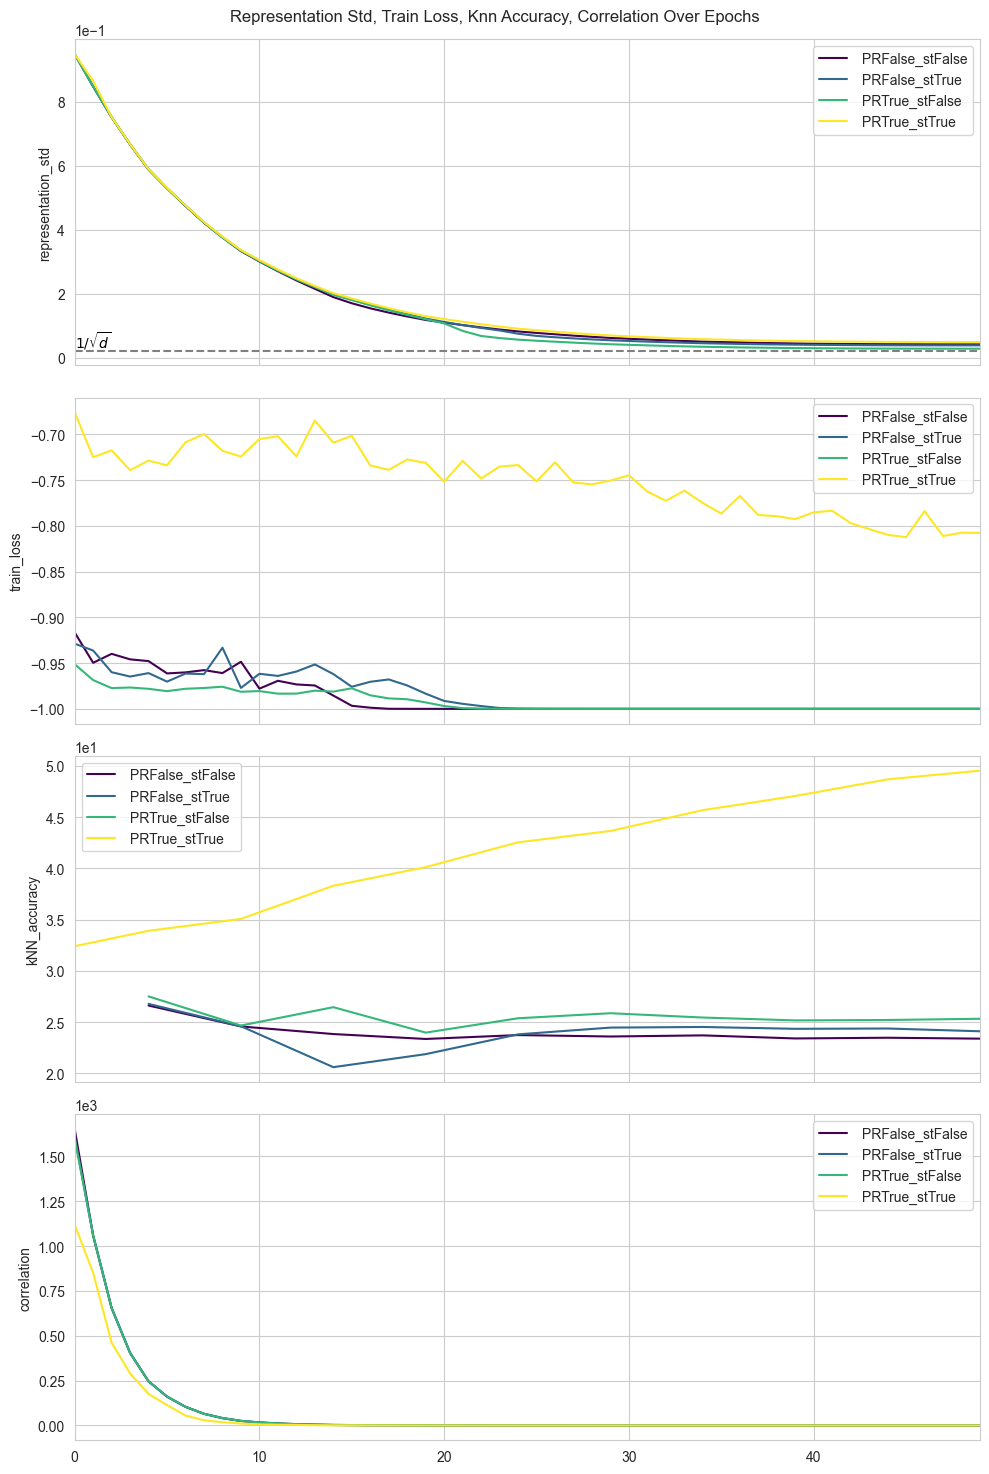

In [22]:

# To use the function, just call:
data = compare_curve("LNeg_VMNone_*",
                    r"LNeg_VMNone_(.*)_b128_m50_v4", 
                    ['representation_std', 'train_loss', 'kNN_accuracy',"correlation"])
 


# Conclusion